# Powerforwardprice and Wind Forecast Modeling

In [1]:
import datetime as dt
import sys
sys.path.insert(0,'../../../..')
from typing import List
import numpy as np
import matplotlib.pyplot as plt
from rivapy.tools.datetime_grid import DateTimeGrid

from rivapy.models import OrnsteinUhlenbeck
from rivapy.models.residual_demand_fwd_model import WindPowerForecastModel, WindPowerForecastModelParameter, MultiRegionWindForecastModel, LinearDemandForwardModel

%load_ext autoreload
%autoreload 2
%matplotlib inline

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Simulation of Powerprices and Wind

In [2]:
params = WindPowerForecastModelParameter(n_call_strikes=40, min_strike=-7.0, max_strike=7.0)
# setup 
wind_region_model = {}
vols = [3.0]#[0.8]
mean_reversion_speed = [0.1]
capacities = [10_000.0]
rnd_weights = [ [1.0]
              ]
np.random.seed(42)
regions = []
for i in range(len(vols)):
    model = WindPowerForecastModel(region='Region_' + str(i), 
                                            speed_of_mean_reversion=mean_reversion_speed[i],
                                            volatility=vols[i], params=params)
    regions.append(MultiRegionWindForecastModel.Region( 
                                    model,
                                    capacity=capacities[i],
                                    rnd_weights=rnd_weights[i]
                                ) )
wind = MultiRegionWindForecastModel('Wind_Germany', regions)

In [3]:
model = LinearDemandForwardModel(wind_power_forecast=wind, 
                                    x_mean_reversion_speed= 0.5, 
                                     x_volatility=1.5,
                                    power_name= 'Power_Germany',
                                additive_correction=False)

In [11]:
timegrid = np.linspace(0.0,2.0/(365.), 2*24)
np.random.seed(42)
rnd = np.random.normal(size=model.rnd_shape(10_000, timegrid.shape[0]))
results = model.simulate(timegrid, rnd, expiries=[timegrid[-1]], 
                         power_fwd_prices=[100.0],
                         initial_forecasts={'Region_0': [0.5]})

In [12]:
print('Keys of simulated values: ', results.keys())
simulated_wind = results.get('Wind_Germany_FWD0')
simulated_power = results.get('Power_Germany_FWD0')
print('final mean power price: ',simulated_power[-1,:].mean() )
print('final mean wind efficiency: ', simulated_wind[-1,:].mean())

Keys of simulated values:  {'Power_Germany_FWD0', 'Wind_Germany_FWD0', 'Region_0_FWD0'}
final mean power price:  100.03956443511706
final mean wind efficiency:  0.4995037490314231


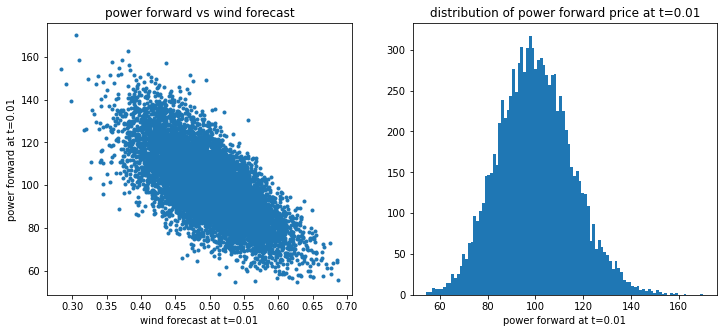

In [13]:
timepoint = 47
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
t = "{:1.2f}".format(timegrid[timepoint]) # current time as string for axis labels
plt.plot(simulated_wind[timepoint,:], simulated_power[timepoint,:],'.')
plt.xlabel('wind forecast at t='+t)
plt.ylabel('power forward at t='+t)
plt.title('power forward vs wind forecast')
plt.subplot(1,2,2)
plt.hist(simulated_power[timepoint,:], bins=100)
plt.xlabel('power forward at t='+t)
plt.title('distribution of power forward price at t='+t);

## Simulation with forecasts at discrete timepoints only

In real life, forecasts arrive at discrete times only. This effect can be handled by simply defining the list of timegridpoints where new forecasts come. This list can then be handed over to the get method of the results.

In [7]:
print('Keys of simulated values: ', results.keys())
forecast_points = [i for i in range(0,timegrid.shape[0],10)] # list of time indices where forecasts arrive
simulated_wind_disc = results.get('Wind_Germany_FWD0', forecast_timepoints=forecast_points) #forecast at 
simulated_power_disc = results.get('Power_Germany_FWD0',forecast_timepoints=forecast_points)
print('final mean power price: ',simulated_power[-1,:].mean() )

Keys of simulated values:  {'Power_Germany_FWD0', 'Wind_Germany_FWD0', 'Region_0_FWD0'}
final mean power price:  100.09524015322565


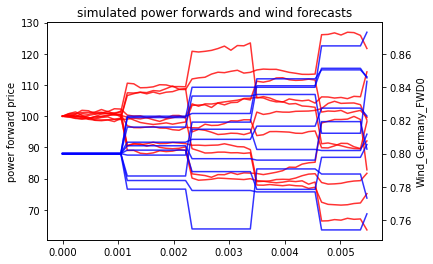

In [145]:
for i in range(10):
    plt.plot(timegrid, simulated_power_disc[:,i],'-r', alpha=0.8)
plt.ylabel('power forward price')
plt.twinx()
for i in range(10):
    plt.plot(timegrid, simulated_wind_disc[:,i],'-b', alpha=0.8)
plt.ylabel('Wind_Germany_FWD0')
plt.xlabel('t')
plt.title('simulated power forwards and wind forecasts');